In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
import pickle
from tensorflow.keras.layers import Embedding,LSTM,Dropout,BatchNormalization,GlobalMaxPooling1D,Dense,Input,Flatten,TimeDistributed
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from hazm import *
import string
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU

In [2]:
df=pd.read_csv('train.csv',low_memory=False)
df1=pd.read_csv('test.csv',low_memory=False)

In [3]:
df

,id,comment,product_id,product_title_fa,category_id,category_title_fa,is_buyer,price_value,fake_originality,warranty,size,discrepancy,flavor_odor,expiration_date
0,1215666.0,ارزششو داشت,2802959,جوراب مردانه فیرو پلاس مدل FP200 مجموعه 4 عددی,9456,جوراب و ساق مردانه,TRUE,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1183149.0,یه دستگاه کاربردی فقط ای کاش طرز استفادشو میزد...,1894596,دستگاه سفید کننده دندان دنتال وایت مدل DT-1244,5745,مسواک برقی,TRUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1011730.0,خیلی خوب و ارزان,323729,کتاب بهترین قصه ملانصرالدین کلک مرغابی اثر مهر...,5918,کتاب چاپی,TRUE,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1093325.0,اندازش خیلیییییی بزرگ بود,1431242,نوار بهداشتی تافته مدل Thin بسته 7 عددی,6528,نوار بهداشتی,TRUE,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1111983.0,خیلی بد بود و میچسبید به دست,1902220,ژل بازی کد shb57,6083,ابزار شوخی,FALSE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179994,1113909.0,خیلی خوب بود و کاربردی,451814,جای کاغذ یادداشت رایدین مدل طلقی به همراه یک ب...,6014,لوازم اداری رومیزی,TRUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179995,1100949.0,+ممنون از فروشنده+\r\n+ممنون از دیجی کالا+,791984,دوشاخه برق الکتروفراز کد 003,1289,چندراهی برق و محافظ ولتاژ,TRUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179996,1161446.0,ماست خوشمزه و با کیفیت,1578085,ماست گلدن پاک - 2.5 کیلوگرم,9216,ماست,TRUE,0.0,0.0,0.0,0.0,0.0,1.0,0.0
179997,1057088.0,به قیمتش می ارزه . خوشگل,1781940,گیره مو کد PK272,9398,اکسسوری مو زنانه,TRUE,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df['is_buyer'].replace('TRUE',True,inplace=True)
df['is_buyer'].replace('FALSE',False,inplace=True)
df.dropna(inplace=True)

In [4]:
df.reset_index(inplace=True)
df['is_buyer'] =df['is_buyer'].map({True:1,False:0})
df1['is_buyer'] =df1['is_buyer'].map({True:1,False:0})
df1.is_buyer.unique()

array([1, 0], dtype=int64)

In [5]:
df['is_buyer'].value_counts()

1    171251
0      8743
Name: is_buyer, dtype: int64

In [6]:
df_train=df.drop(columns=['index','id','product_id','category_id'])
df_test=df1.drop(columns=['id','product_id','category_id'])

In [7]:
df_train["text"] = df_train['comment']
df_test["text"] = df_test['comment']

In [8]:
df_train['length'] = df_train['text'].apply(lambda x: len(x))
df_test['length'] = df_test['text'].apply(lambda x: len(x))

In [9]:
df_train.drop(columns=['comment','category_title_fa','product_title_fa'],inplace=True)
df_test.drop(columns=['comment','category_title_fa','product_title_fa'],inplace=True)

In [10]:
def normalizeing(text):
    normalizer = Normalizer()
    return normalizer.normalize(text)
df_train['text'] = df_train['text'].apply(lambda x: normalizeing(x))
df_test['text'] = df_test['text'].apply(lambda x: normalizeing(x))

In [11]:
def convert_to_lower(text):
    return text.lower()
df_train['text'] = df_train['text'].apply(lambda x: convert_to_lower(x))
df_test['text'] = df_test['text'].apply(lambda x: convert_to_lower(x))

In [12]:
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number
df_train['text'] = df_train['text'].apply(lambda x: remove_numbers(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_numbers(x))

In [13]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
df_train['text'] = df_train['text'].apply(lambda x: remove_punctuation(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punctuation(x))

In [14]:
with open('stopwords.txt',encoding='utf-8') as stopwords_file:
    stopwords=stopwords_file.readlines()
stopwords=[line.replace('\n','') for line in stopwords]
import nltk
nltk.download('stopwords')
nltk_stopwords=nltk.corpus.stopwords.words('english')
stopwords.extend(nltk_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aghil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def remove_stopwords(text):
    removed = []
    stop_words = stopwords
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)
df_train['text'] = df_train['text'].apply(lambda x: remove_stopwords(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopwords(x))

In [16]:
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z0-9آ-ی۰-۹]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc
df_train['text'] = df_train['text'].apply(lambda x: remove_extra_white_spaces(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_extra_white_spaces(x))

In [17]:
def stemmering(text):
    stemmer = Stemmer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = stemmer.stem(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)
df_train['text'] = df_train['text'].apply(lambda x: stemmering(x))
df_test['text'] = df_test['text'].apply(lambda x: stemmering(x))

In [18]:
df_train['length_after_cleaning'] = df_train['text'].apply(lambda x: len(x))
df_test['length_after_cleaning'] = df_test['text'].apply(lambda x: len(x))

In [19]:
df_test.head()

,is_buyer,text,length,length_after_cleaning
0,1,معمولیه کیفیت,56,13
1,1,پول می‌ارزه,36,11
2,1,ای بدک,14,6
3,1,خوبه قیم,38,8
4,1,ظریف,15,4


In [20]:
df_train.head()

,is_buyer,price_value,fake_originality,warranty,size,discrepancy,flavor_odor,expiration_date,text,length,length_after_cleaning
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ارزششو,11,6
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,دستگاه کاربرد طرز استفادشو میزد اینقد نباش,76,42
2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ارز,16,3
3,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,انداز خیلییی,25,12
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,میچسبید دس,28,10


In [21]:
df_train['powerlabel'] = np.array(df_train.apply(lambda x : 64*x["price_value"]+32*x['fake_originality']+
                                       16*x['warranty']+8*x['size']+
                                       4*x['discrepancy']+2*x['flavor_odor']+
                                       1*x['expiration_date'],axis=1))

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
ohe=OneHotEncoder()

In [240]:
x=ohe.fit_transform(np.array(df_train.powerlabel).reshape(-1,1))

In [241]:
label=x.toarray()

In [26]:
buy=np.array(df_train['is_buyer'])
len(buy)

179994

In [27]:
buy_test=np.array(df_test['is_buyer'])
len(buy_test)

44131

In [28]:
# Define the sequence lengths, max number of words and embedding dimensions
MAX_SEQUENCE_LENGTH = 35 #can plot a graph for length
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 200


In [29]:
# Get the frequently occurring words
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_train.text.astype(str))
train_sequences = tokenizer.texts_to_sequences(df_train.text.astype(str))
test_sequences = tokenizer.texts_to_sequences(df_test.text.astype(str))
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

for i in range(len(buy)):
    if buy[i]==1:
        train_sequences[i].append(41701)
    else: train_sequences[i].append(41702)
for i in range(len(buy_test)):
    if buy[i]==1:
        test_sequences[i].append(41701)
    else: test_sequences[i].append(41702)
    
#some padding shit
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post',
    truncating='post')
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post',
    truncating='post')

Found 41620 unique tokens.


In [30]:
label_data=df_train[['price_value', 'fake_originality', 'warranty', 'size','discrepancy', 'flavor_odor', 'expiration_date']]

In [31]:
class_names=['price_value', 'fake_originality', 'warranty', 'size','discrepancy', 'flavor_odor', 'expiration_date']

In [229]:
class_weights = {}
positive_weights = {}
negative_weights = {}

for label in (class_names):
    positive_weights[label] = df_train.shape[0] /(2 * np.count_nonzero(df_train[label] == 1))
    negative_weights[label] = df_train.shape[0] /(2 * np.count_nonzero(df_train[label] == 0))
    
class_weights['positive_weights'] = positive_weights
class_weights['negative_weights'] = negative_weights
class_weights

{'positive_weights': {'price_value': 2.5185257737728772,
  'fake_originality': 71.3695479777954,
  'warranty': 229.5841836734694,
  'size': 6.168825827678388,
  'discrepancy': 11.748955613577024,
  'flavor_odor': 9.91702479338843,
  'expiration_date': 169.16729323308272},
 'negative_weights': {'price_value': 0.6238527658394566,
  'fake_originality': 0.5035276082200825,
  'warranty': 0.5010913018785982,
  'size': 0.5441008433844201,
  'discrepancy': 0.5222242853992828,
  'flavor_odor': 0.5265476629280537,
  'expiration_date': 0.5014822079325986}}

In [261]:
class_weights1={'positive_weights': {'price_value': 1.0178571428571428,
  'fake_originality': 1.2391304347826086,
  'warranty': 2.375,
  'size': 1.3571428571428572,
  'discrepancy': 1.2954545454545454,
  'flavor_odor': 1.3571428571428572,
  'expiration_date': 1.78125},
 'negative_weights': {'price_value': 0.9827586206896551,
  'fake_originality': 0.8382352941176471,
  'warranty': 0.6333333333333333,
  'size': 0.7916666666666666,
  'discrepancy': 0.8142857142857143,
  'flavor_odor': 0.7916666666666666,
  'expiration_date': 0.6951219512195121}}
Wp = class_weights1['positive_weights']
Wn = class_weights1['negative_weights']

def custom_loss(y_true, y_logit):
    '''
    Multi-label cross-entropy
    * Required "Wp", "Wn" as positive & negative class-weights
    y_true: true value
    y_logit: predicted value
    '''
    loss = float(0)
    
    for i, key in enumerate(Wp.keys()):
        first_term = Wp[key] * y_true[i] * K.log(y_logit[i] + K.epsilon())
        second_term = Wn[key] * (1 - y_true[i]) * K.log(1 - y_logit[i] + K.epsilon())
        loss -= (first_term + second_term)
    return loss

In [262]:
def f1_score(y_true, y_logit):
    '''
    Calculate F1 score
    y_true: true value
    y_logit: predicted value
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_logit, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    predicted_positives = K.sum(K.round(K.clip(y_logit, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [263]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [264]:
in1=Input(shape=(MAX_SEQUENCE_LENGTH))
x=Embedding(MAX_NB_WORDS,100)(in1)
x=LSTM(64,return_sequences=True)(x)
x=LSTM(32,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
#x=Dense(50,activation='relu')(x)
#x=Dense(20,activation='relu')(x)
x=Dense(10,activation='relu')(x)
out=Dense(57,activation='sigmoid')(x)

In [265]:
model = Model(inputs=in1, outputs=out)

In [266]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 35)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 35, 100)           2000000   
                                                                 
 lstm_16 (LSTM)              (None, 35, 64)            42240     
                                                                 
 lstm_17 (LSTM)              (None, 35, 32)            12416     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_22 (Dense)            (None, 10)                330       
                                                           

In [267]:
from tensorflow.keras.callbacks import EarlyStopping

pat=EarlyStopping(patience=5)

In [268]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=custom_loss, metrics=['accuracy',f1_score])

In [269]:

history = model.fit(
    train_data, np.array(label), batch_size=512, epochs=50, validation_split=0.3,callbacks=[pat])

Epoch 1/50
247/247 [==============================] - 13s 38ms/step - loss: 3.2550 - accuracy: 0.0232 - f1_score: 0.1350 - val_loss: 2.5544 - val_accuracy: 0.0408 - val_f1_score: 0.1732
Epoch 2/50
247/247 [==============================] - 8s 31ms/step - loss: 2.0392 - accuracy: 0.4487 - f1_score: 0.2681 - val_loss: 1.5767 - val_accuracy: 0.6516 - val_f1_score: 0.3463
Epoch 3/50
247/247 [==============================] - 8s 31ms/step - loss: 1.2786 - accuracy: 0.6495 - f1_score: 0.4550 - val_loss: 1.0001 - val_accuracy: 0.6516 - val_f1_score: 0.4617
Epoch 4/50
247/247 [==============================] - 8s 31ms/step - loss: 0.8380 - accuracy: 0.6495 - f1_score: 0.6384 - val_loss: 0.6770 - val_accuracy: 0.6516 - val_f1_score: 0.6518
Epoch 5/50
247/247 [==============================] - 8s 31ms/step - loss: 0.5830 - accuracy: 0.6495 - f1_score: 0.6495 - val_loss: 0.4937 - val_accuracy: 0.6516 - val_f1_score: 0.6518
Epoch 6/50
247/247 [==============================] - 8s 31ms/step - loss:

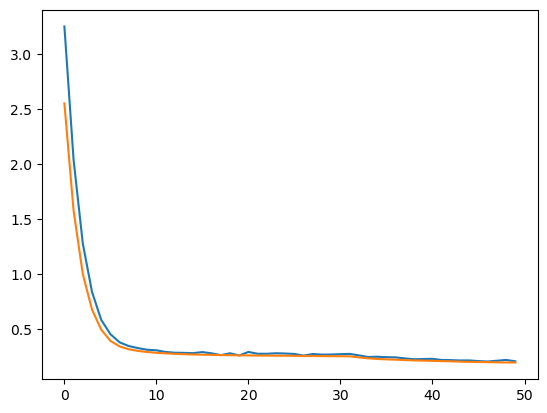

In [270]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

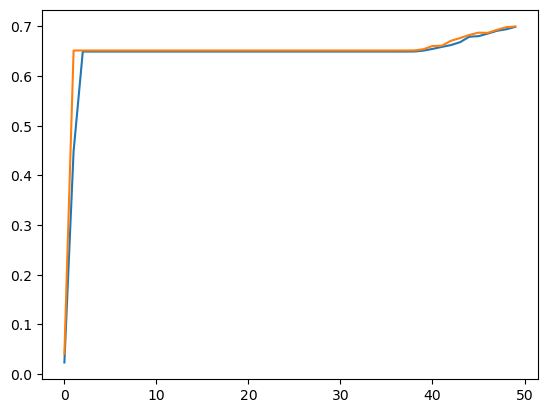

In [271]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

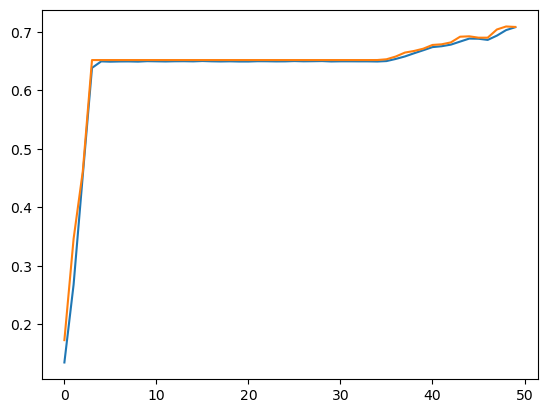

In [272]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

In [273]:
ids=np.array(df1['id'])
ids

array([1052439, 1130800, 1177330, ..., 1149489, 1025940, 1070083],
      dtype=int64)

In [274]:
n=np.array(model.predict(test_data))

1380/1380 [==============================] - 7s 4ms/step


In [275]:
out={'id':[],'price_value':[],'fake_originality':[],'warranty':[],'size':[],'discrepancy':[],'flavor_odor':[],'expiration_date':[]}

In [276]:
for i in range(len(b)):
    biner=bin(int(float(ohe.get_feature_names_out()[n[i].argmax()][3:])))[2:]
    lab=''
    if len(biner)==7:
        lab=biner
    elif len(biner)<7:
        lab=biner+((7-len(biner))*'0')
    out['id'].append(ids[i])
    out['price_value'].append(int(lab[0]))
    out['fake_originality'].append(int(lab[1]))
    out['warranty'].append(int(lab[2]))
    out['size'].append(int(lab[3]))
    out['discrepancy'].append(int(lab[4]))
    out['flavor_odor'].append(int(lab[5]))
    out['expiration_date'].append(int(lab[6]))

In [279]:
pd.DataFrame(out).to_csv('out17.csv')

In [ ]:
for i in range(len(n)):
    for j in range(len(n[i])):
        if n[i][j]>=0.9:
            n[i][j]=1
        else: n[i][j]=0

In [192]:
out1=pd.DataFrame(out,columns=[,,
                              ,,,',
                              ])
out1

,price_value,fake_originality,warranty,size,discrepancy,flavor_odor,expiration_date


In [188]:
pre=pd.concat([df1['id'],out1],axis=1)
pre.head(20)

,id,price_value,fake_originality,warranty,size,discrepancy,flavor_odor,expiration_date
0,1052439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1130800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1177330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1047314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1096710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1164162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1012415,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1039627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1145984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1268145,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
pre.to_csv('out16.csv')

In [280]:
from sklearn.ensemble import RandomForestClassifier

In [281]:
m=RandomForestClassifier()

In [282]:
m.fit(train_data, np.array(label))

RandomForestClassifier()

In [283]:
m.score(train_data, np.array(label))

0.981310488127382

In [285]:
qqq=m.predict(test_data)

In [288]:
pd.DataFrame(qqq).describe()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
count,44131.000000,44131.000000,44131.000000,44131.0,44131.000000,44131.0,44131.0,44131.0,44131.000000,44131.0,...,44131.0,44131.0,44131.0,44131.0,44131.0,44131.0,44131.0,44131.0,44131.0,44131.0
mean,0.667127,0.000272,0.019805,0.0,0.004464,0.0,0.0,0.0,0.015205,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.471247,0.016488,0.139330,0.0,0.066665,0.0,0.0,0.0,0.122368,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [287]:
out={'id':[],'price_value':[],'fake_originality':[],'warranty':[],'size':[],'discrepancy':[],'flavor_odor':[],'expiration_date':[]}

In [ ]:
for i in range(len(b)):
    biner=bin(int(float(ohe.get_feature_names_out()[qqq[i].argmax()][3:])))[2:]
    lab=''
    if len(biner)==7:
        lab=biner
    elif len(biner)<7:
        lab=biner+((7-len(biner))*'0')
    out['id'].append(ids[i])
    out['price_value'].append(int(lab[0]))
    out['fake_originality'].append(int(lab[1]))
    out['warranty'].append(int(lab[2]))
    out['size'].append(int(lab[3]))
    out['discrepancy'].append(int(lab[4]))
    out['flavor_odor'].append(int(lab[5]))
    out['expiration_date'].append(int(lab[6]))